## **Summary from outlier**

1. headshotrate > 0.5
2. damagedealt >= 4000
3. kills > 60
4. killstreak > 10
5. walkdistance > 7.5k
6. weaponacquired > 20
7. heals > 40
8. boosts > 20
9. totaldistance == 0 & kills > 0
10. walkdistance == 0 & kills > 0
11. ridedistance == 0 & roadkills > 0
12. weaponacquired == 0 & winplaceperc > 0.5
13. heals == 0 & winplaceperc > 0.8
14. heals and boosts == 0 & winplaceperc > 0.8
15. one NaN in target value

In [36]:
import os, time, gc
import pandas as pd, numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
os.listdir('input')

['sample_submission_V2.csv',
 'test_V2.csv',
 'te_fe.csv',
 'train_V2.csv',
 'tr_fe.csv',
 'tr_fe.ftr']

## **Make Basic Features**

In [38]:
def feature_engineering(is_train=True,debug=True):
    test_idx = None
    if is_train: 
        print("processing train.csv")
        if debug == True:
            df = pd.read_csv('input/train_V2.csv', nrows=10000)
        else:
            df = pd.read_csv('input/train_V2.csv')           

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test.csv")
        df = pd.read_csv('input/test_V2.csv')
        test_idx = df.Id
    
    # df = reduce_mem_usage(df)
    #df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    
    # df = df[:100]
    
    print("remove some columns")
    target = 'winPlacePerc'

    print("Adding Features")
 
    df['headshotrate'] = df['kills']/df['headshotKills']
    df['killStreakrate'] = df['killStreaks']/df['kills']
    df['healthitems'] = df['heals'] + df['boosts']
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['distance_over_weapons'] = df['totalDistance'] / df['weaponsAcquired']
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['killsPerWalkDistance'] = df['kills'] / df['walkDistance']
    df["skill"] = df["headshotKills"] + df["roadKills"]
    
    df['roadkill_rate'] = df['roadKills']/df['kills']
    df['walkdist_rate'] = df['walkDistance']/df['totalDistance']
    df['swimdist_rate'] = df['swimDistance']/df['totalDistance']
    df['ridedist_rate'] = df['rideDistance']/df['totalDistance']
    
    df['kills_n_assists'] = df['kills'] + df['assists']
    df['kills_n_assists_n_revives'] = df['kills'] + df['assists'] + df['revives']
    df['kills_n_assists_knockouts'] = df['kills_n_assists'] - df['DBNOs']
    df['kills_n_assists_n_revives_knockouts'] = df['kills_n_assists_n_revives'] - df['DBNOs']

    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Removing Na's From DF")
    df.fillna(0, inplace=True)

    
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")
    
    # matchType = pd.get_dummies(df['matchType'])
    # df = df.join(matchType)    
    
    y = None
    
    
    if is_train: 
        print("get target")
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    # print("get group sum feature")
    # agg = df.groupby(['matchId','groupId'])[features].agg('sum')
    # agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    # df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    # df_out = df_out.merge(agg_rank, suffixes=["_sum", "_sum_rank"], how='left', on=['matchId', 'groupId'])
    
    # print("get group sum feature")
    # agg = df.groupby(['matchId','groupId'])[features].agg('sum')
    # agg_rank = agg.groupby('matchId')[features].agg('sum')
    # df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    # df_out = df_out.merge(agg_rank.reset_index(), suffixes=["_sum", "_sum_pct"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    # print("get match type feature")
    # agg = df.groupby(['matchId'])[matchType.columns].agg('mean').reset_index()
    # df_out = df_out.merge(agg, suffixes=["", "_match_type"], how='left', on=['matchId'])
    
    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = df_out
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names, test_idx

In [39]:
x_train, y_train, train_columns, _ = feature_engineering(True,False)

processing train.csv
remove some columns
Adding Features
Removing Na's From DF
get target
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [40]:
x_test, _, _ , test_idx = feature_engineering(False,True)

processing test.csv
remove some columns
Adding Features
Removing Na's From DF
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [41]:
x_train.shape, x_test.shape

((2026744, 303), (1934174, 303))

In [42]:
x_train['target'] = y_train

In [43]:
x_train['is_outlier'] = np.where(x_train['headshotrate']> 0.5, 1, 0)
x_train['is_outlier'] = np.where(x_train['damageDealt']>=4000, 1, 0)
x_train['is_outlier'] = np.where(x_train['kills']> 60, 1, 0)
x_train['is_outlier'] = np.where(x_train['killStreaks']> 10, 1, 0)
x_train['is_outlier'] = np.where(x_train['walkDistance']> 7500, 1, 0)
x_train['is_outlier'] = np.where(x_train['weaponsAcquired']> 20, 1, 0)
x_train['is_outlier'] = np.where(x_train['heals']> 40, 1, 0)
x_train['is_outlier'] = np.where(x_train['boosts']> 20, 1, 0)
x_train['is_outlier'] = np.where((x_train['totalDistance']==0)&(x_train['kills']!=0), 1, 0)
x_train['is_outlier'] = np.where((x_train['walkDistance']==0)&(x_train['kills']!=0), 1, 0)
x_train['is_outlier'] = np.where((x_train['rideDistance']==0)&(x_train['roadKills']!=0), 1, 0)
x_train['is_outlier'] = np.where((x_train['weaponsAcquired']==0)&(x_train['target']>0.5), 1, 0)
x_train['is_outlier'] = np.where((x_train['heals']==0)&(x_train['target']>0.8), 1, 0)
x_train['is_outlier'] = np.where((x_train['healthitems']==0)&(x_train['target']>0.8), 1, 0)

In [44]:
print("The total number of outliers")
print("n = {}".format(x_train['is_outlier'].sum()))
print("% = {}".format(x_train['is_outlier'].sum()/x_train.shape[0]))

The total number of outliers
n = 132
% = 6.512909375826449e-05


In [45]:
print(x_train.shape)
x_train = x_train[x_train['is_outlier']==0]
print(x_train.shape)

(2026744, 305)
(2026612, 305)


In [46]:
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [25]:
%%time
x_train = reduce_mem_usage(x_train)
x_test = reduce_mem_usage(x_test)

c:\users\roal2\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\roal2\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
c:\users\roal2\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [47]:
x_train.head()

,assists_mean,boosts_mean,damageDealt_mean,DBNOs_mean,headshotKills_mean,heals_mean,killPlace_mean,killPoints_mean,kills_mean,killStreaks_mean,...,walkdist_rate,swimdist_rate,ridedist_rate,kills_n_assists,kills_n_assists_n_revives,kills_n_assists_knockouts,kills_n_assists_n_revives_knockouts,match_size,target,is_outlier
0,0.0,0.5,109.675000,1.000000,0.0,0.5,41.0,1242.0,1.0,0.5,...,0.941541,0.001609,0.035797,1.305263,1.463158,0.463158,0.621053,95,0.3333,0
1,0.0,0.0,47.988333,0.333333,0.0,0.0,90.5,1355.5,0.0,0.0,...,0.941541,0.001609,0.035797,1.305263,1.463158,0.463158,0.621053,95,0.0370,0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,94.5,1382.0,0.0,0.0,...,0.941541,0.001609,0.035797,1.305263,1.463158,0.463158,0.621053,95,0.0000,0
3,0.0,0.5,11.700000,0.000000,0.0,0.0,59.5,1178.0,0.0,0.0,...,0.941541,0.001609,0.035797,1.305263,1.463158,0.463158,0.621053,95,0.3704,0
4,1.0,3.5,340.950000,2.500000,1.0,1.0,14.0,1504.0,3.0,1.5,...,0.941541,0.001609,0.035797,1.305263,1.463158,0.463158,0.621053,95,1.0000,0


In [48]:
x_train.shape, x_test.shape

((2026612, 305), (1934174, 303))

In [49]:
x_train.dtypes.value_counts()

float64    252
int64       52
int32        1
dtype: int64

In [50]:
x_train.head()

,assists_mean,boosts_mean,damageDealt_mean,DBNOs_mean,headshotKills_mean,heals_mean,killPlace_mean,killPoints_mean,kills_mean,killStreaks_mean,...,walkdist_rate,swimdist_rate,ridedist_rate,kills_n_assists,kills_n_assists_n_revives,kills_n_assists_knockouts,kills_n_assists_n_revives_knockouts,match_size,target,is_outlier
0,0.0,0.5,109.675000,1.000000,0.0,0.5,41.0,1242.0,1.0,0.5,...,0.941541,0.001609,0.035797,1.305263,1.463158,0.463158,0.621053,95,0.3333,0
1,0.0,0.0,47.988333,0.333333,0.0,0.0,90.5,1355.5,0.0,0.0,...,0.941541,0.001609,0.035797,1.305263,1.463158,0.463158,0.621053,95,0.0370,0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,94.5,1382.0,0.0,0.0,...,0.941541,0.001609,0.035797,1.305263,1.463158,0.463158,0.621053,95,0.0000,0
3,0.0,0.5,11.700000,0.000000,0.0,0.0,59.5,1178.0,0.0,0.0,...,0.941541,0.001609,0.035797,1.305263,1.463158,0.463158,0.621053,95,0.3704,0
4,1.0,3.5,340.950000,2.500000,1.0,1.0,14.0,1504.0,3.0,1.5,...,0.941541,0.001609,0.035797,1.305263,1.463158,0.463158,0.621053,95,1.0000,0


# Build Model

**Train model w/o outliers**

In [52]:
# exclude target and outlier columns
base_feat = x_train.drop(['target','is_outlier'],axis=1).columns.tolist()
train_Y = x_train['target']

In [53]:
len(base_feat)

303

Make object type to category for lightgbm model to take.

In [55]:
x_train[base_feat].dtypes.value_counts()

float64    251
int64       52
dtype: int64

In [56]:
import time
from sklearn import metrics
from operator import itemgetter
import lightgbm as lgb

In [57]:
from sklearn.model_selection import train_test_split
def LGB_HOLDOUT_REG(size_ratio, train_X, test_X, metric, is_shuffle):
    X_tr,X_val,y_tr,y_val = train_test_split(train_X, train_Y, train_size = size_ratio, shuffle=is_shuffle)

    val_lgb = np.zeros(len(X_val))
    predictions = np.zeros(len(test_X))
    
    # Model parameters
    lgb_params = {'num_leaves': 300,
                 'min_data_in_leaf': 20, 
                 'objective':'regression',
                 'max_depth': -1,
                 'learning_rate': 0.005,
                 "boosting": "gbdt",
                 "feature_fraction": 0.9,
                 "bagging_freq": 1,
                 "bagging_fraction": 0.9,
                 "bagging_seed": 42,
                 "metric": metric,
                 "lambda_l1": 0.0,
                 "verbosity": 500,
                 "nthread": -1,
                 "random_state": 42}

    model_start = time.time()

    model = lgb.LGBMRegressor(**lgb_params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric=metric,
              verbose=500, 
              early_stopping_rounds=200)
    val_lgb = model.predict(X_val, num_iteration=model.best_iteration_)

    cv_score = model.best_score_

    #feature importance
    feature_importance_df = pd.DataFrame()
    feature_importance_df["Feature"] = train_X.columns
    feature_importance_df["importance"] = model.feature_importances_[:len(train_X.columns)]

    #predictions
    predictions = model.predict(test_X, num_iteration=model.best_iteration_)

    print("-" * 50)
    print("HOLD_OUT "+ metric + " = {}".format(cv_score))
    lgb.plot_metric(model, metric=metric, title='auc plot', xlabel='Iterations', ylabel='auto', figsize=(10,8), grid=False)

    model_end = time.time()
    model_elapsed = model_end - model_start
    print('Model elapsed {0:0.2f}'.format(model_elapsed/60), "minutes.")

    # FEATURE IMPORTANCE
    pd.set_option('display.max_rows', 500)
    feature_importance_df['Feature Rank'] = feature_importance_df['importance'].rank(ascending=0)
    feature_importance_df = feature_importance_df.sort_values('Feature Rank', ascending = True)
    print(feature_importance_df.loc[feature_importance_df['importance']!=0].head(100))

    return predictions, val_lgb, cv_score, feature_importance_df

Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.0420277	valid_1's l1: 0.0423059
[1000]	training's l1: 0.0304464	valid_1's l1: 0.0310078
[1500]	training's l1: 0.0285846	valid_1's l1: 0.029379
[2000]	training's l1: 0.0276089	valid_1's l1: 0.0286291
[2500]	training's l1: 0.0268935	valid_1's l1: 0.0281314
[3000]	training's l1: 0.0263268	valid_1's l1: 0.0277783
[3500]	training's l1: 0.0258415	valid_1's l1: 0.027501
[4000]	training's l1: 0.0254289	valid_1's l1: 0.0272939
[4500]	training's l1: 0.0250588	valid_1's l1: 0.0271211
[5000]	training's l1: 0.0247217	valid_1's l1: 0.0269745
[5500]	training's l1: 0.0244118	valid_1's l1: 0.0268485
[6000]	training's l1: 0.0241222	valid_1's l1: 0.0267369
[6500]	training's l1: 0.0238449	valid_1's l1: 0.0266305
[7000]	training's l1: 0.0235845	valid_1's l1: 0.0265371
[7500]	training's l1: 0.0233316	valid_1's l1: 0.0264451
[8000]	training's l1: 0.0230959	valid_1's l1: 0.0263687
[8500]	training's l1: 0.0228658	valid_1's l1:

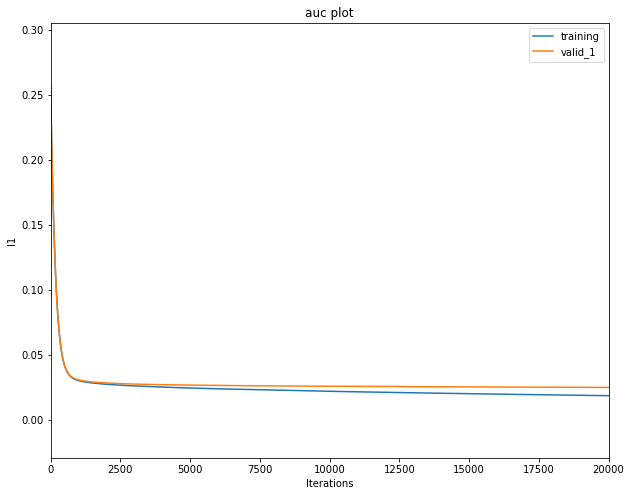

In [58]:
pred, val, cv, feat = LGB_HOLDOUT_REG(0.8, x_train[base_feat], x_test[base_feat], 'l1', is_shuffle=True)

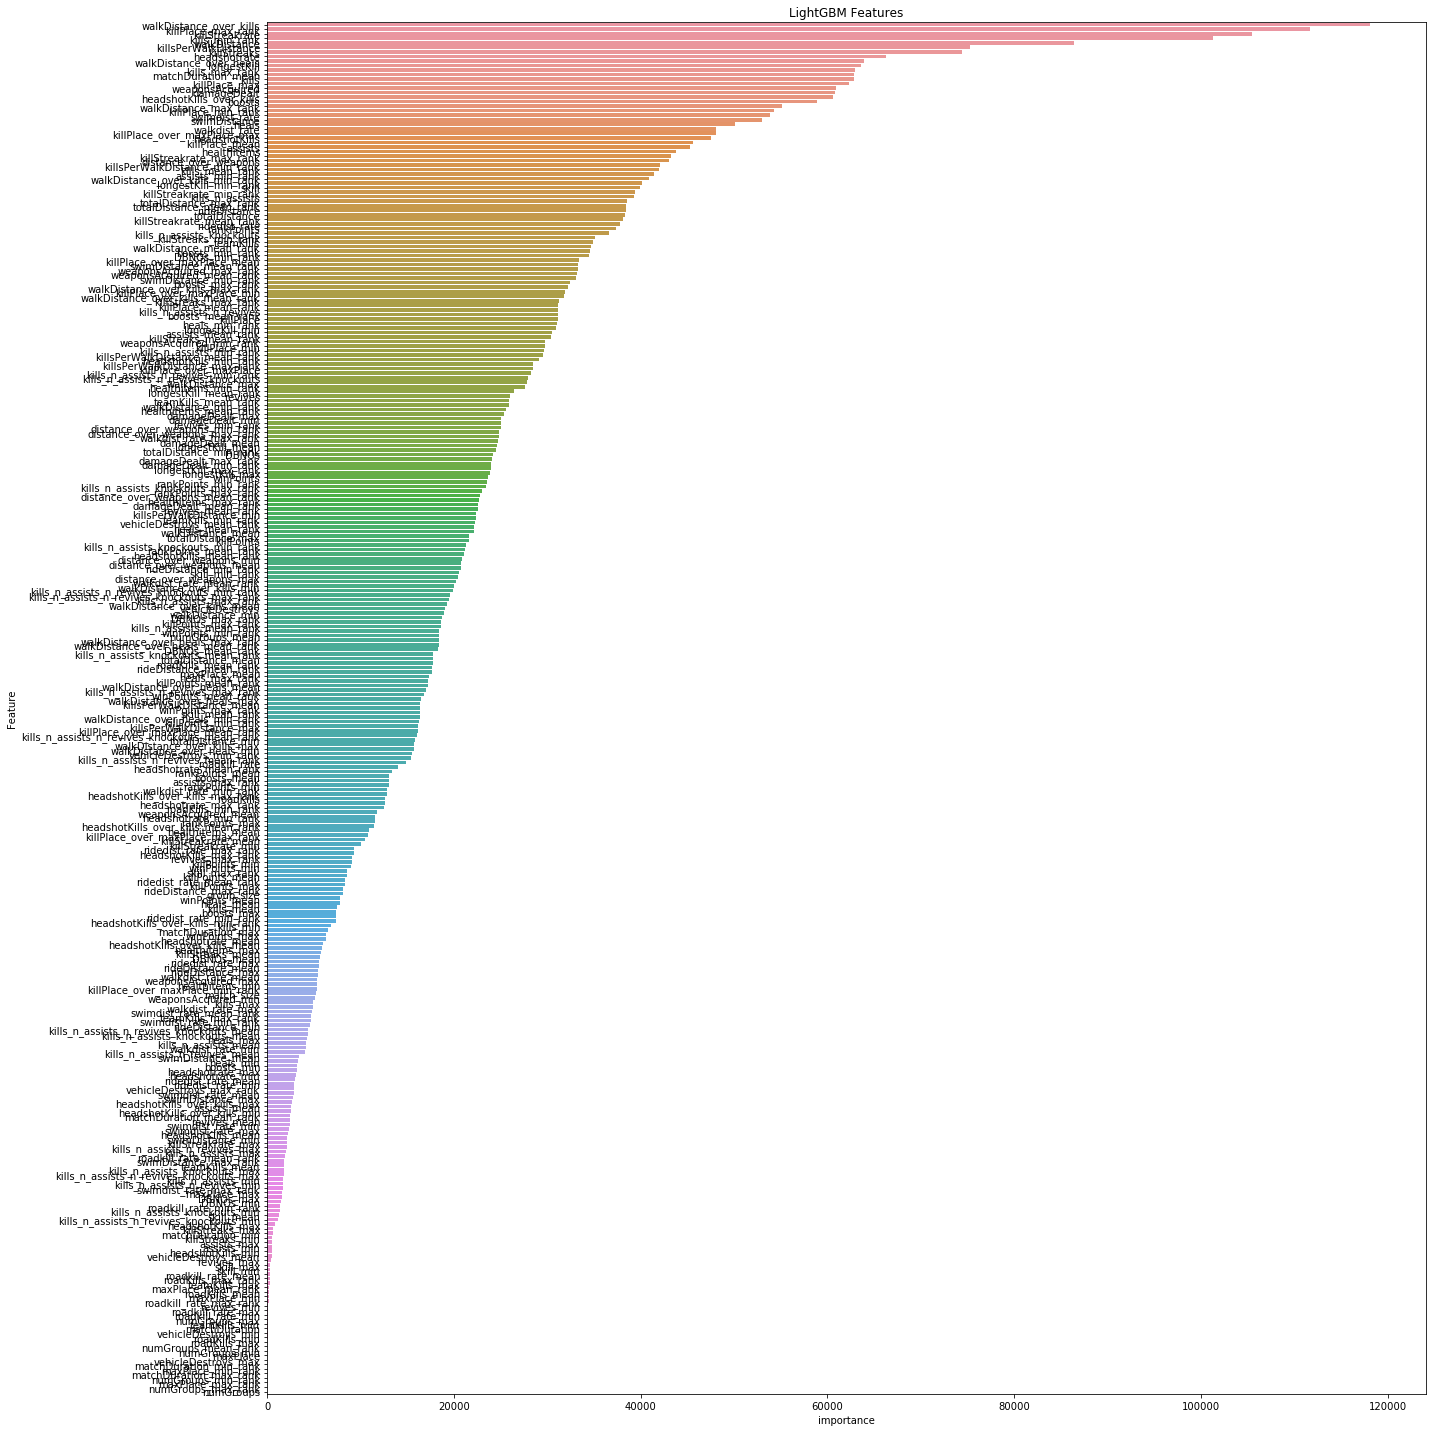

In [60]:
plt.figure(figsize=(20, 20))
sns.barplot(x="importance", y="Feature", data=feat)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()